In [1]:
import os
from itertools import chain, repeat, compress
from pathlib import Path

import autoreject
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from autoreject import get_rejection_threshold
from scipy.integrate import simpson
from mne_icalabel import label_components
from Settings import *
from utils import *

In [2]:
mne.set_log_level(False)
try:
    mne.cuda.init_cuda(verbose=True)
    mne.utils.set_config('MNE_USE_CUDA', 'true') 
finally:
    cuda=True


plt.rcParams.update({'figure.max_open_warning': 0})

#all ICAs to compute
icas = []
clean_raws = {}

Now using CUDA device 0
Enabling CUDA with 8.85 GB available memory
Enabling CUDA with 8.85 GB available memory


In [3]:
lstPIds = []
for filename in os.listdir(path):
    if filename.endswith(".csv"): 
        lstPIds.append(int(filename.split("-")[0].replace("ID", "")))
    else:
        continue
lstPIds = list(set(lstPIds))
print(lstPIds)
print(str(len(lstPIds)) + " subjects")

if TEST:
    lstPIds = [1, 2]
    lstPIds = list(set(lstPIds))
    NUM_BLOCKS = 2

[1, 2]
2 subjects


In [4]:
arr_raws = []

dir_path = r'./fifs/'

Path(dir_path).mkdir(parents=True, exist_ok=True)
Path('./ica/fifs').mkdir(parents=True, exist_ok=True)
Path('./pickles').mkdir(parents=True, exist_ok=True)
Path('./ica/epochs').mkdir(parents=True, exist_ok=True)
Path('./Plots/ICA').mkdir(parents=True, exist_ok=True)
Path('./Plots/NoICA').mkdir(parents=True, exist_ok=True)

#TODO: add option to recompute anyways
if len(os.listdir('./fifs')) != NUM_BLOCKS * len(lstPIds):
    for pid in tqdm.tqdm(lstPIds):

        dfState = pd.read_csv(f"{path}ID{pid}-state.csv")
            
        dfEEG = pd.read_csv(f"{path}ID{pid}-EEG.csv")
        # dfEEG.rename(columns={"Value0": "F3", "Value1": "C3", "Value2": "P3", "Value3": "P4", "Value4": "C4", "Value5": "F4", "Value6": "Pz"}, inplace=True)
        dfEEG.drop("TimeLsl", axis =1, inplace=True)

        dstate = pd.read_csv(f"{path}ID{pid}-state.csv")

        dfAll = pd.merge(dfEEG, dstate, on =["Time"], how="outer")
        dfAll.sort_values(by="Time", inplace=True)

        dfAll = dfAll.drop(columns=["AdaptationStatus", "NBackN", "State"] )
        dfAll.fillna(method='ffill', inplace=True)
        dfAll.drop(dfAll[dfAll.BlockNumber < 0].index, inplace=True)
        dfAll.dropna(inplace=True)
            

        for x in range(1, NUM_BLOCKS+1):  
            
            # Prepare data 
            print(x)
            data = dfAll.loc[dfAll['BlockNumber'] == x]
            df = pd.DataFrame(data)

            info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
            info.set_montage('standard_1020',  match_case=False)

            samples = df.T
            
            raw = mne.io.RawArray(samples, info)
            raw.drop_channels(['Time', 'BlockNumber'])
            
            #remove power line interferance
            raw.notch_filter(50., n_jobs=-1)
            
            #high pass filter to remove slow drifts, 70 Hz low pass
            raw.filter(1., 100.)
            
            # set eeg reference
            raw.set_eeg_reference('average')
            
            # Visual inspection of bad channels
            # TODO, empty list for now. With new setup, check for bad channels only once for all blocks.
            raw.info['bads'] =  bads[pid-1][x-1]
            if raw.info['bads'] != []:
                raw.interpolate_bads()   
            
            #arr_raws.append(raw)
            raw.save('./fifs/' + str(pid) + '-' + str(x) + '_eeg.fif', overwrite = True)

  0%|          | 0/2 [00:00<?, ?it/s]

1
2
3


<ipython-input-4-bddcdb4f2303>:50: RuntimeWarning: filter_length (3301) is longer than the signal (833), distortion is likely. Reduce filter length or filter a longer signal.
  raw.notch_filter(50., n_jobs=-1)
<ipython-input-4-bddcdb4f2303>:53: RuntimeWarning: filter_length (1651) is longer than the signal (833), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(1., 100.)


4
5


 50%|█████     | 1/2 [00:09<00:09,  9.79s/it]

1
2
3
4
5


100%|██████████| 2/2 [00:16<00:00,  8.43s/it]


In [5]:
exclude_ic = [] # TODO sure its here?
action = None

for pid in tqdm.tqdm(lstPIds):
    
    
    for x in range(1, NUM_BLOCKS+1):  
        
        raw = mne.io.read_raw_fif('./fifs/' + str(pid) + '-' + str(x) + '_eeg.fif', preload=True)

        # independent component analysis (ICA)                
        if len(os.listdir('./ica/fifs/')) != NUM_BLOCKS * len(lstPIds):
            ica = mne.preprocessing.ICA(method="infomax",random_state = 97, fit_params=dict(extended=True))
            
            ica.fit(raw)
                
            labels = label_components(raw, ica, method='iclabel')
            #print('labels are ' , labels['labels'])

            idx_exclude = [idx for idx, label  in enumerate (labels['labels']) if label != 'brain']
            #ica.plot_overlay(raw, exclude=idx_exclude, picks='eeg', stop = 360., title= str(pid) + '-' + str(x))
            #ica.plot_components()
            
            ica.exclude = idx_exclude
            # ica.labels_['exclude'] = idx_exclude
            ica.save('./ica/fifs/' + str(pid) + '-' + str(x) + '-ica.fif', overwrite = True) 
            #epochs.save('./ica/epochs/' + str(pid) + '-' + str(x) + '-epo.fif', overwrite = True)
          
        else:
            ica = mne.preprocessing.read_ica('./ica/fifs/' + str(pid) + '-' + str(x) + '-ica.fif')
            #epochs = mne.read_epochs('./ica/epochs/' + str(pid) + '-' + str(x) + '-epo.fif', preload=True)
                     
        #TODO put this somewhere else
        clean_ica_excludes = False
        if(clean_ica_excludes):
            ica.exclude = []
            ica.save('./ica/fifs/' + str(pid) + '-' + str(x) + '-ica.fif', overwrite = True)

        icas.append(ica)
        arr_raws.append(raw)
        
        # raw.save("./ica/pipeline_1/raw/"+str(pid)+"_"+str(x)+".fif")

100%|██████████| 2/2 [12:30<00:00, 375.17s/it]


In [6]:
ica_templates = []

dir_path = r'./ica/'

clean_raws = np.zeros((len(lstPIds), NUM_BLOCKS),dtype=object)

p = 0
b = 0
for i, ica in enumerate(icas):
    b += 1
    p = p + 1 if i % 7 == 0 else p
    if p == 4: p = 5 
    if p == 8:  p = 9
    if p == 10: p = 11
    b = 1 if  b == 8 else b

    #n.plot_overlay(arr_raws[i], n.exclude, picks='eeg',  title=("Pid "+ str(p) +" block " +str(b)), stop = 360.)
    ica.apply(arr_raws[i], exclude=ica.exclude) # TODO at least i hope so, double check indices

# # for whatever reason i cant convert the arr_raws array to numpy to do the reshape :D 
# i could look into it. later.
for i in range(len(lstPIds)):
    for j in range(NUM_BLOCKS):
        clean_raws[i][j] = arr_raws[j%NUM_BLOCKS+i*NUM_BLOCKS]

# TODO save preprocessed raws        
#raw.save("./ica/pipeline_1/raw/"+str(pid)+"_"+str(x)+".fif")

In [7]:
pws_lst = list()
for n, pid in enumerate(tqdm.tqdm(lstPIds)):
 
    for x in range(START_BLOCK,NUM_BLOCKS+1):
                
        
        raw = clean_raws[n][x-1]

        #plot alpha and theta 
        if(plot_plots):
            
            fig = plt.figure( figsize=(7, 3))
            subfigs = fig.subfigures(1, 2, wspace=0.07, width_ratios=[3., 1.])
            axs0 = subfigs[0].subplots(2, 1)
            subfigs[0].set_facecolor('0.9')

            raw.compute_psd(method='multitaper', fmin=bands.theta[0], fmax = bands.theta[1]).plot(dB=False, axes = axs0[1], show = False)
            raw.compute_psd(method='multitaper', fmin=bands.alpha[0], fmax = bands.alpha[1]).plot(dB = False, axes = axs0[0], show = False) 
        
            axs1 = subfigs[1].subplots(2, 1)
            raw.compute_psd(method='multitaper', fmin=bands.theta[0], fmax = bands.theta[1]).plot_topo(dB = False, axes = axs1[0], show = False)
            raw.compute_psd(method='multitaper', fmin=bands.alpha[0], fmax = bands.alpha[1]).plot_topo(dB = False, axes = axs1[1], show = False)
            
            fig.set_constrained_layout(True)
            fig.suptitle("PID " + str(pid) + " block " + str(x))
            if(save_plots):
                filepath = "../Plots/PID_" + str(pid) + "-Block_" + str(x)  + "-raw_psd_topo.png"
                plt.savefig(filepath)
 
        ### Compute the power spectral density (PSD)
                
        for grp_nr in range(len(channel_groups)):
            
            #pick channels for different frequencies
            picks = mne.pick_types(raw.info, eeg=True)
            picks_alpha = mne.pick_types(raw.info, eeg=True, exclude=mask_channels(channel_groups[grp_nr][0]))
            picks_theta = mne.pick_types(raw.info, eeg=True, exclude=mask_channels(channel_groups[grp_nr][1]))

            for m, method in enumerate(methods):
                
                print('PID' , pid, 'Blocknr' , x, 'method' , method, 'group' , grp_nr)
                njob = "cuda" if cuda else -1
                n_jobs = njob if method != 'welch' else 2 #NOTE: this is a bug in NME, welch with raw does not support using all cpus
                
                psds, freqs = get_psd(raw, method, picks, n_jobs) 
                # psds /= np.sum(psds, axis=-1, keepdims=True) 
                psds_mean = psds.mean(0)
                freq_res = freqs[1] - freqs[0]
                
                psds_alpha, freqs_alpha = get_psd(raw, method, picks_alpha, n_jobs)  
                psds_mean_alpha = psds_alpha.mean(0)
                freq_res_alpha = freqs_alpha[1] - freqs_alpha[0]
                
                psds_theta, freqs_theta = get_psd(raw, method, picks_theta, n_jobs)            
                psds_mean_theta = psds_theta.mean(0)
                freq_res_theta = freqs_theta[1] - freqs_theta[0]
                
                # Find intersecting values in frequency vector
                idx_alpha = np.logical_and(freqs_alpha >= bands.alpha[0], freqs_alpha <= bands.alpha[1])
                idx_theta = np.logical_and(freqs_theta >= bands.theta[0], freqs_theta <= bands.theta[1])      
            
                # absolute power
                bp_alpha = simpson(psds_mean_alpha[idx_alpha], dx=freq_res_alpha)
                bp_theta = simpson(psds_mean_theta[idx_theta], dx=freq_res_theta) 
                bp_total = simpson(psds_mean, dx=freq_res)
                
                # relative power
                bp_alpha_rel =  bp_alpha / bp_total # alpha relative power
                bp_theta_rel = bp_theta / bp_total # theta relative power

                alpha_theta_total = bp_alpha / bp_theta
                alpha_theta_rel = bp_alpha_rel / bp_theta_rel       
                
                #peak power at freq
                peak_alpha = freqs_alpha[np.argmax(psds_mean_alpha[idx_alpha])]
                peak_theta = freqs_theta[np.argmax(psds_mean_theta[idx_theta])]
                
                if(plot_plots):

                    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
                    for ind, (label, band_def) in enumerate(bands):
                        
                        # Create a topomap for the current oscillation bandca
                        raw.compute_psd(method=method).plot_topomap({label: band_def}, ch_type='eeg', cmap = 'viridis', show_names=True, normalize=True, axes=axes[0, ind], show=False)

                        idx = np.logical_and(freqs >= band_def[0], freqs <=  band_def[1])
                        axes[0,ind].set_title(method + " PSD topo " + label + ' power ' + str(grp_nr), {'fontsize' : 7})

                        psds_std = (psds_mean[idx]).std(0)
                        peak = freqs[np.argmax(psds_mean[idx])]
                        axes[1,ind].plot(freqs[idx], psds_mean[idx], color='k')
                        axes[1,ind].fill_between(freqs[idx], psds_mean[idx] - psds_std, psds_mean[idx] + psds_std,
                                        color='k', alpha=.5)
                        axes[1,ind].set_title(method + " PSD " + label + ' power', {'fontsize' : 7})
                    
                    fig.suptitle("PID " + str(pid) + " block " + str(x) + " " + str(grp_nr))
                    fig.set_constrained_layout(True)
                    
                    if(save_plots):
                        filepath = "../Plots/PID_" + str(pid) + "-Block_" + str(x) + "-Group_" + str(grp_nr) + ".png"
                        plt.savefig(filepath)
            
                pws_lst.append([pid, x, bp_alpha, bp_theta, alpha_theta_total, grp_nr, method])
                   
        if(draw_plots):

            plt.show()

  0%|          | 0/2 [00:00<?, ?it/s]

PID 1 Blocknr 1 method multitaper group 0
PID 1 Blocknr 1 method welch group 0
PID 1 Blocknr 1 method multitaper group 1
PID 1 Blocknr 1 method welch group 1
PID 1 Blocknr 2 method multitaper group 0
PID 1 Blocknr 2 method welch group 0
PID 1 Blocknr 2 method multitaper group 1
PID 1 Blocknr 2 method welch group 1


<ipython-input-7-ff96a791d209>:73: RuntimeWarning: invalid value encountered in scalar divide
  alpha_theta_total = bp_alpha / bp_theta
<ipython-input-7-ff96a791d209>:74: RuntimeWarning: invalid value encountered in scalar divide
  alpha_theta_rel = bp_alpha_rel / bp_theta_rel


PID 1 Blocknr 3 method multitaper group 0


c:\Users\p_kar\Documents\Tese\2022-IUI-AdaptiveSystem\AdaptiveEEGSystem\Pipeline_2\utils.py:18: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  spectrum = instance.compute_psd(method = method, n_jobs=n, picks=picks)
c:\Users\p_kar\Documents\Tese\2022-IUI-AdaptiveSystem\AdaptiveEEGSystem\Pipeline_2\utils.py:18: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  spectrum = instance.compute_psd(method = method, n_jobs=n, picks=picks)
c:\Users\p_kar\Documents\Tese\2022-IUI-AdaptiveSystem\AdaptiveEEGSystem\Pipeline_2\utils.py:18: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  spectrum = instance.compute_psd(method = method, n_jobs=n, picks=picks)


PID 1 Blocknr 3 method welch group 0
PID 1 Blocknr 3 method multitaper group 1


c:\Users\p_kar\Documents\Tese\2022-IUI-AdaptiveSystem\AdaptiveEEGSystem\Pipeline_2\utils.py:18: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  spectrum = instance.compute_psd(method = method, n_jobs=n, picks=picks)
c:\Users\p_kar\Documents\Tese\2022-IUI-AdaptiveSystem\AdaptiveEEGSystem\Pipeline_2\utils.py:18: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  spectrum = instance.compute_psd(method = method, n_jobs=n, picks=picks)
c:\Users\p_kar\Documents\Tese\2022-IUI-AdaptiveSystem\AdaptiveEEGSystem\Pipeline_2\utils.py:18: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  spectrum = instance.compute_psd(method = method, n_jobs=n, picks=picks)


PID 1 Blocknr 3 method welch group 1
PID 1 Blocknr 4 method multitaper group 0


c:\Users\p_kar\Documents\Tese\2022-IUI-AdaptiveSystem\AdaptiveEEGSystem\Pipeline_2\utils.py:18: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  spectrum = instance.compute_psd(method = method, n_jobs=n, picks=picks)
c:\Users\p_kar\Documents\Tese\2022-IUI-AdaptiveSystem\AdaptiveEEGSystem\Pipeline_2\utils.py:18: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  spectrum = instance.compute_psd(method = method, n_jobs=n, picks=picks)
c:\Users\p_kar\Documents\Tese\2022-IUI-AdaptiveSystem\AdaptiveEEGSystem\Pipeline_2\utils.py:18: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  spectrum = instance.compute_psd(method = method, n_jobs=n, picks=picks)


PID 1 Blocknr 4 method welch group 0
PID 1 Blocknr 4 method multitaper group 1


c:\Users\p_kar\Documents\Tese\2022-IUI-AdaptiveSystem\AdaptiveEEGSystem\Pipeline_2\utils.py:18: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  spectrum = instance.compute_psd(method = method, n_jobs=n, picks=picks)
c:\Users\p_kar\Documents\Tese\2022-IUI-AdaptiveSystem\AdaptiveEEGSystem\Pipeline_2\utils.py:18: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  spectrum = instance.compute_psd(method = method, n_jobs=n, picks=picks)
c:\Users\p_kar\Documents\Tese\2022-IUI-AdaptiveSystem\AdaptiveEEGSystem\Pipeline_2\utils.py:18: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  spectrum = instance.compute_psd(method = method, n_jobs=n, picks=picks)


PID 1 Blocknr 4 method welch group 1
PID 1 Blocknr 5 method multitaper group 0


c:\Users\p_kar\Documents\Tese\2022-IUI-AdaptiveSystem\AdaptiveEEGSystem\Pipeline_2\utils.py:18: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  spectrum = instance.compute_psd(method = method, n_jobs=n, picks=picks)
c:\Users\p_kar\Documents\Tese\2022-IUI-AdaptiveSystem\AdaptiveEEGSystem\Pipeline_2\utils.py:18: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  spectrum = instance.compute_psd(method = method, n_jobs=n, picks=picks)
c:\Users\p_kar\Documents\Tese\2022-IUI-AdaptiveSystem\AdaptiveEEGSystem\Pipeline_2\utils.py:18: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  spectrum = instance.compute_psd(method = method, n_jobs=n, picks=picks)


PID 1 Blocknr 5 method welch group 0
PID 1 Blocknr 5 method multitaper group 1


c:\Users\p_kar\Documents\Tese\2022-IUI-AdaptiveSystem\AdaptiveEEGSystem\Pipeline_2\utils.py:18: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  spectrum = instance.compute_psd(method = method, n_jobs=n, picks=picks)
c:\Users\p_kar\Documents\Tese\2022-IUI-AdaptiveSystem\AdaptiveEEGSystem\Pipeline_2\utils.py:18: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  spectrum = instance.compute_psd(method = method, n_jobs=n, picks=picks)
c:\Users\p_kar\Documents\Tese\2022-IUI-AdaptiveSystem\AdaptiveEEGSystem\Pipeline_2\utils.py:18: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  spectrum = instance.compute_psd(method = method, n_jobs=n, picks=picks)


PID 1 Blocknr 5 method welch group 1


 50%|█████     | 1/2 [02:15<02:15, 135.72s/it]

PID 2 Blocknr 1 method multitaper group 0
PID 2 Blocknr 1 method welch group 0
PID 2 Blocknr 1 method multitaper group 1
PID 2 Blocknr 1 method welch group 1
PID 2 Blocknr 2 method multitaper group 0
PID 2 Blocknr 2 method welch group 0
PID 2 Blocknr 2 method multitaper group 1
PID 2 Blocknr 2 method welch group 1
PID 2 Blocknr 3 method multitaper group 0


c:\Users\p_kar\Documents\Tese\2022-IUI-AdaptiveSystem\AdaptiveEEGSystem\Pipeline_2\utils.py:18: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  spectrum = instance.compute_psd(method = method, n_jobs=n, picks=picks)
c:\Users\p_kar\Documents\Tese\2022-IUI-AdaptiveSystem\AdaptiveEEGSystem\Pipeline_2\utils.py:18: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  spectrum = instance.compute_psd(method = method, n_jobs=n, picks=picks)
c:\Users\p_kar\Documents\Tese\2022-IUI-AdaptiveSystem\AdaptiveEEGSystem\Pipeline_2\utils.py:18: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  spectrum = instance.compute_psd(method = method, n_jobs=n, picks=picks)


PID 2 Blocknr 3 method welch group 0
PID 2 Blocknr 3 method multitaper group 1


c:\Users\p_kar\Documents\Tese\2022-IUI-AdaptiveSystem\AdaptiveEEGSystem\Pipeline_2\utils.py:18: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  spectrum = instance.compute_psd(method = method, n_jobs=n, picks=picks)
c:\Users\p_kar\Documents\Tese\2022-IUI-AdaptiveSystem\AdaptiveEEGSystem\Pipeline_2\utils.py:18: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  spectrum = instance.compute_psd(method = method, n_jobs=n, picks=picks)
c:\Users\p_kar\Documents\Tese\2022-IUI-AdaptiveSystem\AdaptiveEEGSystem\Pipeline_2\utils.py:18: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  spectrum = instance.compute_psd(method = method, n_jobs=n, picks=picks)


PID 2 Blocknr 3 method welch group 1
PID 2 Blocknr 4 method multitaper group 0


c:\Users\p_kar\Documents\Tese\2022-IUI-AdaptiveSystem\AdaptiveEEGSystem\Pipeline_2\utils.py:18: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  spectrum = instance.compute_psd(method = method, n_jobs=n, picks=picks)
c:\Users\p_kar\Documents\Tese\2022-IUI-AdaptiveSystem\AdaptiveEEGSystem\Pipeline_2\utils.py:18: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  spectrum = instance.compute_psd(method = method, n_jobs=n, picks=picks)
c:\Users\p_kar\Documents\Tese\2022-IUI-AdaptiveSystem\AdaptiveEEGSystem\Pipeline_2\utils.py:18: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  spectrum = instance.compute_psd(method = method, n_jobs=n, picks=picks)


PID 2 Blocknr 4 method welch group 0
PID 2 Blocknr 4 method multitaper group 1


c:\Users\p_kar\Documents\Tese\2022-IUI-AdaptiveSystem\AdaptiveEEGSystem\Pipeline_2\utils.py:18: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  spectrum = instance.compute_psd(method = method, n_jobs=n, picks=picks)
c:\Users\p_kar\Documents\Tese\2022-IUI-AdaptiveSystem\AdaptiveEEGSystem\Pipeline_2\utils.py:18: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  spectrum = instance.compute_psd(method = method, n_jobs=n, picks=picks)
c:\Users\p_kar\Documents\Tese\2022-IUI-AdaptiveSystem\AdaptiveEEGSystem\Pipeline_2\utils.py:18: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  spectrum = instance.compute_psd(method = method, n_jobs=n, picks=picks)


PID 2 Blocknr 4 method welch group 1
PID 2 Blocknr 5 method multitaper group 0


c:\Users\p_kar\Documents\Tese\2022-IUI-AdaptiveSystem\AdaptiveEEGSystem\Pipeline_2\utils.py:18: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  spectrum = instance.compute_psd(method = method, n_jobs=n, picks=picks)
c:\Users\p_kar\Documents\Tese\2022-IUI-AdaptiveSystem\AdaptiveEEGSystem\Pipeline_2\utils.py:18: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  spectrum = instance.compute_psd(method = method, n_jobs=n, picks=picks)
c:\Users\p_kar\Documents\Tese\2022-IUI-AdaptiveSystem\AdaptiveEEGSystem\Pipeline_2\utils.py:18: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  spectrum = instance.compute_psd(method = method, n_jobs=n, picks=picks)


PID 2 Blocknr 5 method welch group 0
PID 2 Blocknr 5 method multitaper group 1


c:\Users\p_kar\Documents\Tese\2022-IUI-AdaptiveSystem\AdaptiveEEGSystem\Pipeline_2\utils.py:18: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  spectrum = instance.compute_psd(method = method, n_jobs=n, picks=picks)
c:\Users\p_kar\Documents\Tese\2022-IUI-AdaptiveSystem\AdaptiveEEGSystem\Pipeline_2\utils.py:18: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  spectrum = instance.compute_psd(method = method, n_jobs=n, picks=picks)
c:\Users\p_kar\Documents\Tese\2022-IUI-AdaptiveSystem\AdaptiveEEGSystem\Pipeline_2\utils.py:18: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  spectrum = instance.compute_psd(method = method, n_jobs=n, picks=picks)


PID 2 Blocknr 5 method welch group 1


100%|██████████| 2/2 [04:26<00:00, 133.09s/it]


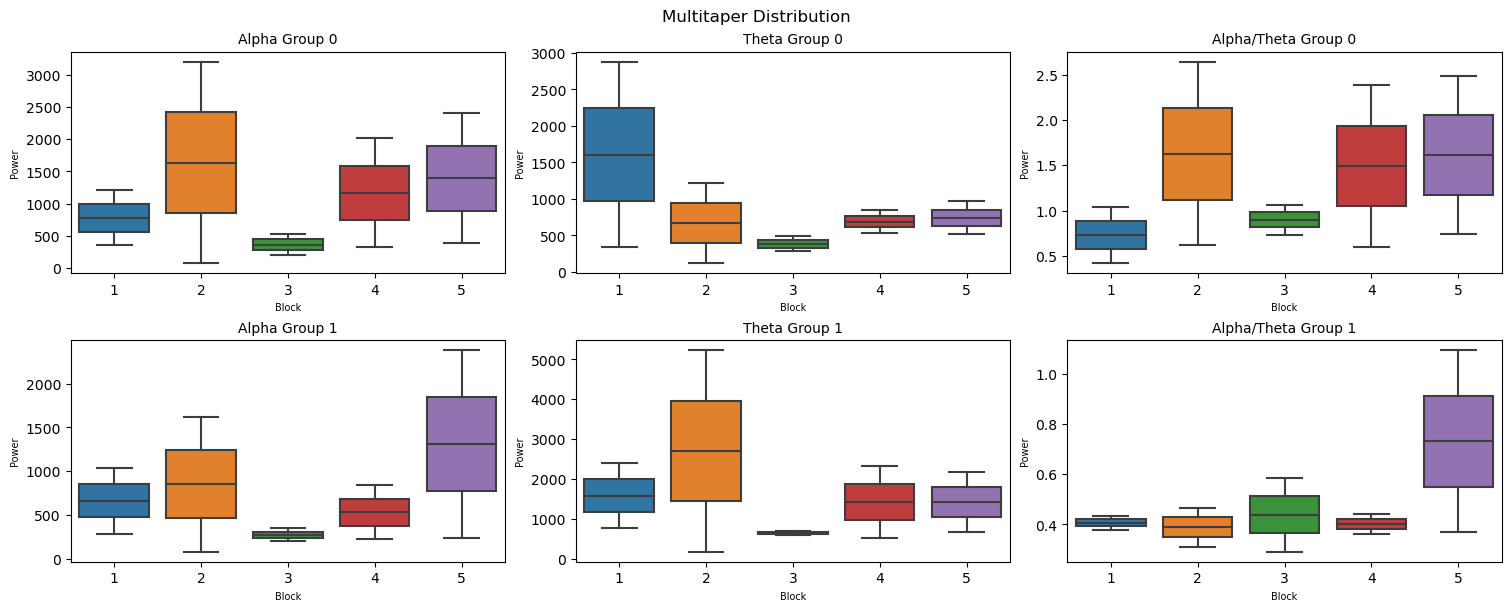

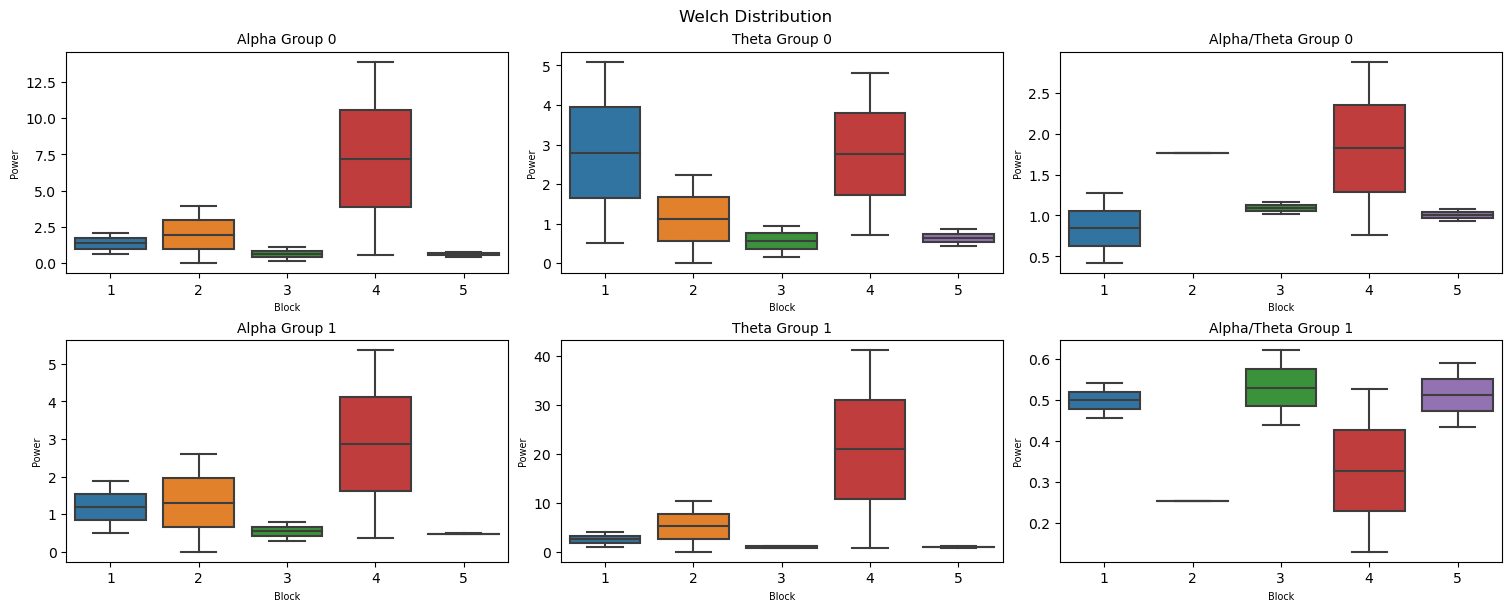

In [8]:
n_ch_grps = len(channel_groups)
calc_powers = ['Alpha', 'Theta', 'Alpha/Theta']

f, axes = plt.subplots(n_ch_grps, len(calc_powers), figsize=(15,6), constrained_layout=True, squeeze=False)
dfPowers = pd.DataFrame(pws_lst, columns =['PID', 'BlockNumber', 'Alpha', 'Theta', 'Alpha/Theta', 'Group', 'Method'])
ax_idx = 1 if len(axes) > 1 else 0

for ch_grp in range(n_ch_grps):
    for calc_power, ax1 in enumerate(axes[ax_idx]):
        sns.boxplot(x = "BlockNumber", y = calc_powers[calc_power], data = dfPowers.loc[(dfPowers['Group'] == ch_grp) & (dfPowers['Method'] == 'multitaper')], ax=axes[ch_grp,calc_power],showfliers=False)
        sns.stripplot(x="BlockNumber", y = calc_powers[calc_power], data=dfPowers.loc[(dfPowers['Group'] == ch_grp) & (dfPowers['Method'] == 'Multitaper')], marker="o", alpha=0.3, color="black", ax=axes[ch_grp,calc_power])
        axes[ch_grp,calc_power].set_title( str(calc_powers[calc_power]) + " Group " + str(ch_grp), fontsize=10)
        axes[ch_grp,calc_power].set_ylabel('Power', fontsize=7)
        axes[ch_grp,calc_power].set_xlabel('Block', fontsize=7)
f.suptitle("Multitaper Distribution")

f, axes = plt.subplots(n_ch_grps, len(calc_powers), figsize=(15,6), constrained_layout=True, squeeze=False)
ax_idx = 1 if len(axes) > 1 else 0

for ch_grp in range(n_ch_grps):
    for calc_power, ax1 in enumerate(axes[ax_idx]):
        sns.boxplot(x = "BlockNumber", y = calc_powers[calc_power], data = dfPowers.loc[(dfPowers['Group'] == ch_grp) & (dfPowers['Method'] == 'welch')], ax=axes[ch_grp,calc_power],showfliers=False)
        axes[ch_grp,calc_power].set_title( str(calc_powers[calc_power]) + " Group " +  str(ch_grp), fontsize=10)
        axes[ch_grp,calc_power].set_ylabel('Power', fontsize=7)
        axes[ch_grp,calc_power].set_xlabel('Block', fontsize=7)
f.suptitle("Welch Distribution")

plt.show()

In [9]:
dfPowers.to_pickle('./pickles/dfPowers.pickle')